# 1 Introduction

I'm going to understand the Markov Chain Monte Carlo algorithm by implementing it in this notebook. Then I will try to run it on the IRT data I have.

# 2 MCMC Model

## 2.1 Definition

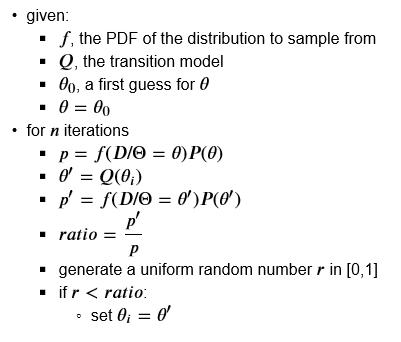

## 2.2 Python Implementation

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
data = pd.read_csv('IRT tutorial/ouirt.dat')

In [78]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [np.random.normal(x[0],0.5,(1,)),np.random.normal(x[1],0.5,(1,))]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
            rejected.append([np.nan]*len(param_init))
        else:
            rejected.append(x_new)
            accepted.append([np.nan]*len(param_init))
                
    accepted = np.array(accepted).reshape(len(accepted), len(param_init))
    rejected = np.array(rejected).reshape(len(rejected), len(param_init))
    
    return accepted, rejected

9.841650809236203 3.0168353542812425


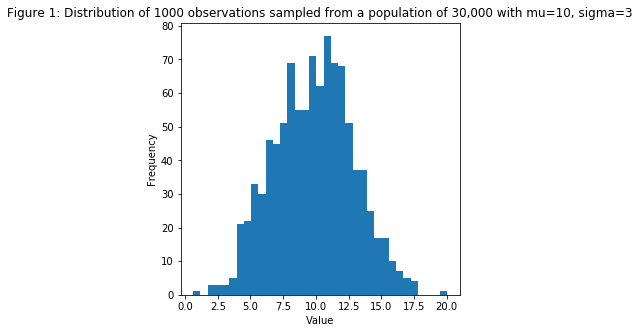

In [79]:
mod1 = lambda t: np.random.normal(10,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3")
mu_obs=observation.mean()
std_obs = observation.std()
print(mu_obs, std_obs)

In [80]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,
                                         prior,
                                         transition_model,
                                         param_init = [15,1],
                                         iterations = 50000,
                                         data = observation,
                                         acceptance_rule = acceptance)

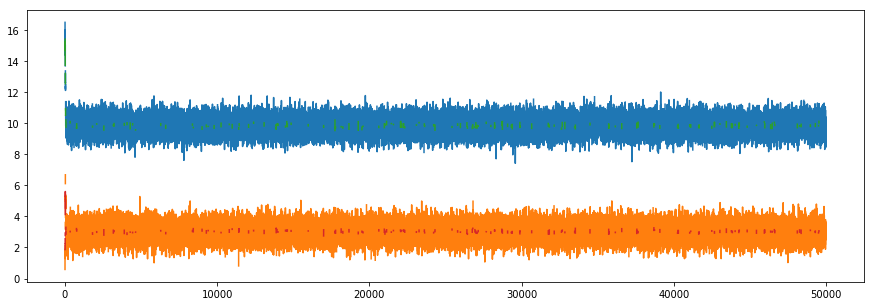

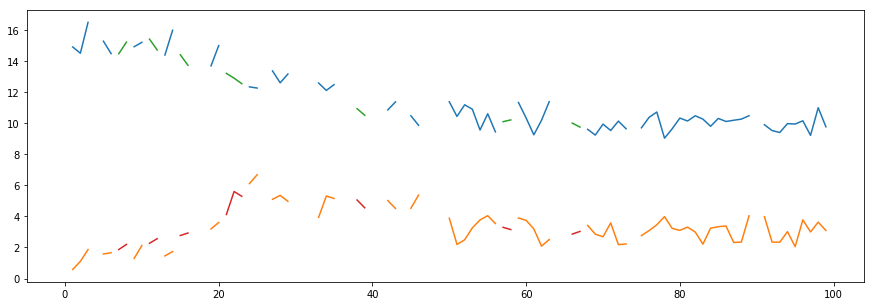

In [88]:
plt.rcParams["figure.figsize"] = (15,5)

plt.plot(rejected)
plt.plot(accepted)
plt.show()

plt.plot(rejected[:100])
plt.plot(accepted[:100])
plt.show()

In [ ]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [np.random.normal(x[0],0.5,(1,)), np.random.normal(x[1],0.5,(1,))]

def prior(x):
    # I don't think there is any prior required here?
    return 1

# log likelihood of logistic function?
def logistic_likelihood(x, data):
    return np.exp(-x[0]+x[1]) / (1 + np.exp(-x[0]+x[1]))**2

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
            rejected.append([np.nan]*len(param_init))
        else:
            rejected.append(x_new)
            accepted.append([np.nan]*len(param_init))
                
    accepted = np.array(accepted).reshape(len(accepted), len(param_init))
    rejected = np.array(rejected).reshape(len(rejected), len(param_init))
    
    return accepted, rejected

In [ ]:
def prior(theta):
    if(x[1] <= 0):
        return 0
    return 1

def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < (np.exp(x_new - x)))

def likelihood(x, data):
    return np.sum(-np.log(x[1] * np.sqrt(2*np.pi)) - ((data-x[0])**2) / (2*x[1]**2))
    
x = param_init
accepted = []
rejected = []   
for i in range(iterations):
    x_new = [x[0], np.random.normal(x[1],0.5,(1,))] 
    likelihood_x = likelihood(x, data)
    likelihood_x_new = likelihood(x_new, data) 
    if accept(likelihood_x + np.log(prior(x)), likelihood_x_new + np.log(prior(x_new))):            
        x = x_new
        accepted.append(x_new)